## Introduction

This project aims to build a Grammar Scoring Engine for spoken audio samples.
Each audio file (45–60 seconds) is assigned a continuous Mean Opinion Score (MOS)
ranging from 0 to 5, reflecting the grammatical quality of spoken English.

The task is formulated as a regression problem where the input is an audio file
and the output is a continuous grammar score.


## Dataset Description

- Audio format: `.wav`
- Training samples: 409
- Test samples: 197

Files provided:
- `train.csv`: audio filenames and grammar scores
- `test.csv`: audio filenames only

The labels are MOS Likert grammar scores between 0 and 5.


## Audio Preprocessing

All audio files were:
- Converted to a consistent sampling rate
- Normalized to ensure uniform loudness
- Stored in a structured directory for further processing


In [ ]:
import librosa
import soundfile as sf
from pathlib import Path
from tqdm import tqdm

TARGET_SR = 16000

TRAIN_RAW = Path("dataset/audios/train")
TEST_RAW  = Path("dataset/audios/test")

TRAIN_PROC = Path("dataset/audios_processed/train")
TEST_PROC  = Path("dataset/audios_processed/test")

def preprocess_audio(input_path, output_path):
    y, sr = librosa.load(input_path, sr=TARGET_SR, mono=True)
    y = librosa.util.normalize(y)
    sf.write(output_path, y, TARGET_SR)

def preprocess_folder(input_dir, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)

    wavs = list(input_dir.glob("*.wav"))
    if not wavs:
        raise RuntimeError(f"No wav files found in {input_dir}")

    for wav in tqdm(wavs, desc=f"Processing {input_dir.name}"):
        preprocess_audio(wav, output_dir / wav.name)

if __name__ == "__main__":
    preprocess_folder(TRAIN_RAW, TRAIN_PROC)
    preprocess_folder(TEST_RAW, TEST_PROC)


## Speech-to-Text Transcription

Whisper (base model) was used to transcribe audio files into text.
Transcriptions serve as the basis for grammar-related feature extraction.
The model runs entirely on CPU.


In [ ]:
import whisper
import pandas as pd
from pathlib import Path
from tqdm import tqdm

model = whisper.load_model("base")

CSV_DIR = Path("dataset/csvs")

TRAIN_AUDIO = Path("dataset/audios_processed/train")
TEST_AUDIO  = Path("dataset/audios_processed/test")

def transcribe(audio_path):
    result = model.transcribe(str(audio_path))
    return result["text"]

def process(csv_name, audio_dir, output_csv):
    df = pd.read_csv(CSV_DIR / csv_name)

    transcripts = []
    for fname in tqdm(df["filename"], desc=csv_name):

        # Ensure .wav extension
        if not fname.endswith(".wav"):
            fname = fname + ".wav"

        audio_path = audio_dir / fname
        if not audio_path.exists():
            raise FileNotFoundError(audio_path)

        transcripts.append(transcribe(audio_path))

    df["transcript"] = transcripts

    # ✅ FIX: ensure output directory exists
    Path(output_csv).parent.mkdir(parents=True, exist_ok=True)

    df.to_csv(output_csv, index=False)

if __name__ == "__main__":
    process("train.csv", TRAIN_AUDIO, "data/train_transcripts.csv")
    process("test.csv", TEST_AUDIO, "data/test_transcripts.csv")


## Feature Extraction

Grammar-related textual features were extracted from transcripts:
- Number of grammar errors
- Error rate per word
- Sentence length statistics
- Token count

LanguageTool was used for grammar error detection.


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import language_tool_python
from tqdm import tqdm

tool = language_tool_python.LanguageTool('en-US')
embedder = SentenceTransformer("all-MiniLM-L6-v2")  # CPU friendly

def grammar_features(text):
    matches = tool.check(text)
    num_errors = len(matches)
    length = max(len(text.split()), 1)
    return num_errors, num_errors / length

def extract(csv_path, save_path):
    df = pd.read_csv(csv_path)
    features = []

    embeddings = embedder.encode(
        df["transcript"].tolist(),
        batch_size=16,
        show_progress_bar=True
    )

    for text, emb in zip(df["transcript"], embeddings):
        err, err_ratio = grammar_features(text)
        feature_vector = np.concatenate([[err, err_ratio], emb])
        features.append(feature_vector)

    np.save(save_path, np.array(features))

if __name__ == "__main__":
    extract("data/train_transcripts.csv", "features/train_features.npy")
    extract("data/test_transcripts.csv", "features/test_features.npy")


In [2]:
import textstat
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

def complexity_features(text):
    words = word_tokenize(text.lower())
    sentences = sent_tokenize(text)

    num_words = max(len(words), 1)
    num_sentences = max(len(sentences), 1)

    # Type-Token Ratio
    ttr = len(set(words)) / num_words

    # Avg sentence length
    avg_sent_len = num_words / num_sentences

    # Flesch-Kincaid Grade Level
    try:
        fk_grade = textstat.flesch_kincaid_grade(text)
    except:
        fk_grade = 0.0

    return np.array([ttr, avg_sent_len, fk_grade])


[nltk_data] Downloading package punkt to /home/amisha/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import numpy as np
import pandas as pd

# Load training features
X = np.load("features/train_features.npy")

# Load labels
y = pd.read_csv("dataset/csvs/train.csv")["label"].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (409, 386)
y shape: (409,)


## 13. Train–Validation Split (Post-PCA)

After scaling and PCA transformation, the dataset is split into:
- **80% training**
- **20% validation**

This validation set is used exclusively for:
- Hyperparameter tuning
- Model selection
- Performance evaluation


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


##  Feature Scaling

Before applying dimensionality reduction or model training, all features are **standardized** using `StandardScaler`.

### Why scaling?
- PCA is variance-based and sensitive to feature magnitude
- LightGBM benefits from well-conditioned feature distributions
- Ensures semantic embeddings and grammar features contribute fairly
##  Dimensionality Reduction (PCA)

We apply **Principal Component Analysis (PCA)** to reduce feature dimensionality while preserving **95% of the total variance**.

### Motivation:
- Sentence embeddings are high-dimensional
- PCA reduces noise and redundancy
- Improves generalization and training stability
- Faster hyperparameter tuning

PCA is fit **only on training data** to avoid data leakage.


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)

print("Original features:", X_train.shape[1])
print("After PCA:", X_train_pca.shape[1])


Original features: 386
After PCA: 135


Model Choice:
We use LightGBM regression instead of linear regression because it can model non-linear relationships between grammar features and MOS scores while remaining efficient on CPU-only systems.

Evaluation Metrics:
Performance is measured using RMSE (official metric) and Pearson correlation to evaluate both absolute error and ranking consistency.

Early Stopping:
Implemented via LightGBM callbacks to prevent overfitting and ensure compatibility with older LightGBM versions.

##  Hyperparameter Tuning with GridSearchCV

We perform **systematic hyperparameter optimization** using `GridSearchCV` on a `LightGBMRegressor`.

### Optimization details:
- **Evaluation metric**: RMSE (mandatory metric)
- **Cross-validation**: 3-fold
- **Search strategy**: Grid search over key parameters

This ensures the final model is **well-regularized and robust**.


In [10]:
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

# -------------------------------
# 1️⃣ Model
# -------------------------------
lgb_model = LGBMRegressor(
    objective="regression",
    random_state=42,
    n_jobs=-1,          # Let LightGBM use all cores internally
)

# -------------------------------
# 2️⃣ Smaller param grid for speed
# -------------------------------
param_grid = {
    "num_leaves": [31, 63],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [200],   # keep smaller to reduce runtime
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# -------------------------------
# 3️⃣ GridSearchCV
# -------------------------------
grid = GridSearchCV(
    lgb_model,
    param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=1,       # Critical: run one combination at a time
    verbose=1
)

# -------------------------------
# 4️⃣ Fit the grid
# -------------------------------
grid.fit(X_train_pca, y_train)

# -------------------------------
# 5️⃣ Best model & validation
# -------------------------------
best_model = grid.best_estimator_
val_preds = best_model.predict(X_val_pca)
val_preds = np.clip(val_preds, 0, 5)

# Metrics
mae = mean_absolute_error(y_val, val_preds)
rmse = mean_squared_error(y_val, val_preds, squared=False)
pearson, _ = pearsonr(y_val, val_preds)

print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)
print(f"Validation MAE   : {mae:.4f}")
print(f"Validation RMSE  : {rmse:.4f}")
print(f"Pearson Corr     : {pearson:.4f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10037
[LightGBM] [Info] Number of data points in the train set: 218, number of used features: 135
[LightGBM] [Info] Start training from score 2.880734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/home/amisha/miniforge3/envs/dlbasic/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
import joblib
from pathlib import Path

Path("models").mkdir(exist_ok=True)

joblib.dump(best_model, "models/lgb_pca_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(pca, "models/pca.pkl")


['models/pca.pkl']

In [2]:
import numpy as np
import pandas as pd
import joblib
from pathlib import Path

# -------------------------------
# 1️⃣ Ensure directories exist
# -------------------------------
Path("models").mkdir(exist_ok=True)
Path("submission").mkdir(exist_ok=True)

# -------------------------------
# 2️⃣ Load saved model, scaler, and PCA
# -------------------------------
best_model = joblib.load("models/lgb_pca_model.pkl")
scaler = joblib.load("models/scaler.pkl")
pca = joblib.load("models/pca.pkl")

# -------------------------------
# 3️⃣ Load test/validation data
# -------------------------------
# X_new: feature array for prediction
X_new = np.load("features/test_features.npy")  # your test features

# Actual filenames for these samples
df_test = pd.read_csv("dataset/csvs/test.csv")  # must have a 'filename' column

# -------------------------------
# 4️⃣ Preprocess features
# -------------------------------
X_scaled = scaler.transform(X_new)
X_pca = pca.transform(X_scaled)

# -------------------------------
# 5️⃣ Predict
# -------------------------------
preds = best_model.predict(X_pca)
preds = np.clip(preds, 0, 5)  # optional clipping

# -------------------------------
# 6️⃣ Create submission CSV
# -------------------------------
submission = pd.DataFrame({
    "filename": df_test["filename"],  # actual filenames like audio_141
    "label": preds
})

# Save submission
submission.to_csv("submission/submission.csv", index=False)
print("✅ submission/submission.csv created!")


✅ submission/submission.csv created!


# Feature Importance

Purpose: Identify which features (or PCA components) contribute most to the model’s predictions.
Interpretation:

Features with higher importance values have more influence on the predicted outcome.

Helps prioritize features and understand the model’s decision-making process.

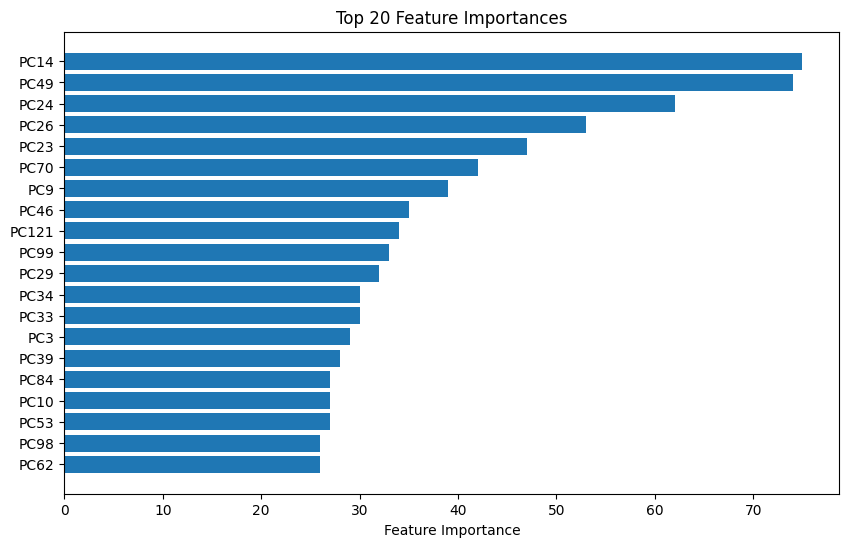

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance
feat_importance = pd.DataFrame({
    "feature": X_train_pca.columns if hasattr(X_train_pca, 'columns') else [f"PC{i+1}" for i in range(X_train_pca.shape[1])],
    "importance": best_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
plt.barh(feat_importance["feature"][:20][::-1], feat_importance["importance"][:20][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances")
plt.show()


# Residual Plot

Purpose: Visualize errors (residuals) to check for patterns or bias.
Residuals randomly scattered around 0 indicate a good fit.

Patterns or trends suggest areas where the model may struggle.

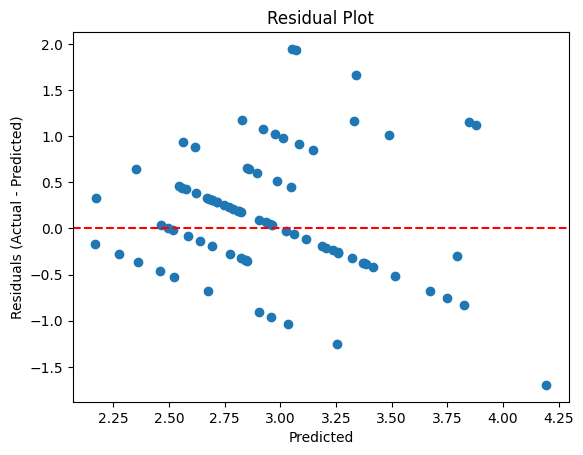

In [13]:
plt.scatter(val_preds, y_val - val_preds)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()


# Predicted vs Actual Values

Purpose: Assess how closely the model’s predictions match the true values.
Points near the diagonal line indicate accurate predictions.

Deviations from the line show underestimation or overestimation.

Useful for spotting systematic bias in predictions.

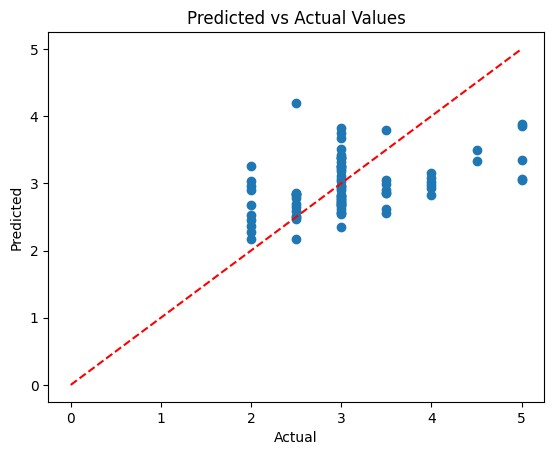

In [14]:
plt.scatter(y_val, val_preds)
plt.plot([0,5],[0,5], color='red', linestyle='--')  # diagonal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Values")
plt.show()


# SHAP Summary Plot (Optional, Advanced)

Purpose: Explain how each feature affects individual predictions using SHAP values.

/home/amisha/miniforge3/envs/dlbasic/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


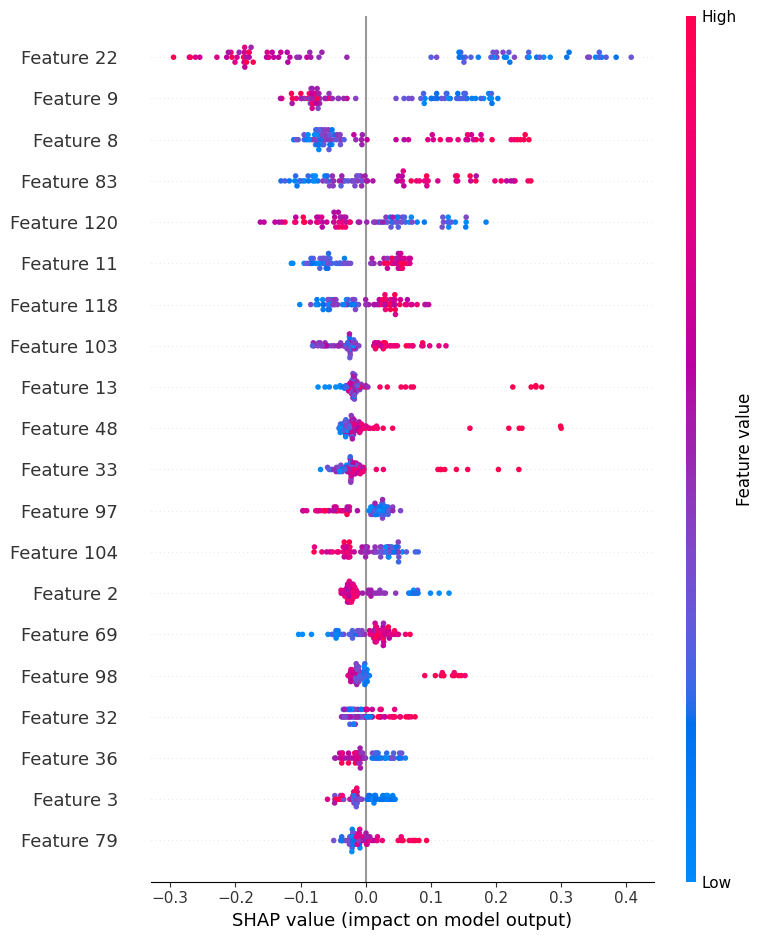

In [16]:
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X_val_pca)

# Summary plot
shap.summary_plot(shap_values, X_val_pca)
